In [ ]:
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from  sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
import shap

sns.set()
%matplotlib inline
shap.initjs()

**Data**

*  **Target variable** - company total revenues
*  **Features** - smartphone sales

**Pipeline**

1. **Load data** - get data from a file
2. **Explore trend and seasionality** - explore trend and seasonality in the data
3. **Dimensionality reduction** - perform dimensionality reduction via Principal Component Analysis (PCA)
4. **Data scaling** - transform data to the same scale for better results
5. **Data encoding** - encode some variables to dummies
6. **Prepare train vs test sets** - split train and tests sets
7. **Model e** - split train and tests sets


### **1. Load Data**

In [ ]:
data = pd.read_csv('data/total_revenues_smartphone_sales_datetime.csv')
data['date'] = pd.to_datetime(data['Month'])
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter
data['year'] = data['date'].dt.year
data.sort_values('date', inplace=True)
data.drop('Month', axis=1, inplace=True)
data.head()

,total_revenues,Alcatel,Apple,Asus,BlackBerry,Coolpad,Fujitsu,Gionee,HMD,HTC,Huawei,iTel,Lenovo,LG,Meizu,Micromax,Motorola,Nokia,Oppo,Others,Panasonic,Pantech,Samsung,Sharp,Sony,Tecno,Vivo,Wiko,Xiaomi,ZTE,Grand Total,date,month,quarter,year
0,182254000.0,0.02,18.6,0.20,13.8,1.60,1.4,0.7,0.0,9.60,2.3,0.0,1.0,4.1025,0.10,0.00,4.10,24.2,0.0,5.4982,0.05,0.43,12.5993,1.1,4.0,0.0,0.0,0.0,0.00,1.4,106.80,2011-03-01,3,1,2011
1,191644000.0,0.14,20.3,0.25,12.6,1.80,1.5,1.0,0.0,11.85,3.0,0.0,1.3,6.1995,0.10,0.00,4.40,16.7,0.0,6.7520,0.05,0.60,20.1985,1.0,4.4,0.0,0.0,0.0,0.00,2.5,116.64,2011-06-01,6,2,2011
2,210185000.0,0.35,17.1,0.25,11.7,2.15,1.2,1.3,0.0,13.15,4.8,0.0,1.7,4.4030,0.20,0.00,4.90,16.8,0.0,7.7655,0.10,0.85,28.1015,1.2,6.2,0.0,0.0,0.0,0.08,3.6,127.90,2011-09-01,9,3,2011
3,208291000.0,0.55,37.0,0.25,13.4,3.20,1.6,1.7,0.0,10.20,6.7,0.0,5.0,5.5020,0.25,0.00,5.30,19.6,0.0,8.0380,0.15,1.22,36.5000,1.2,6.4,0.0,0.0,0.0,0.40,5.4,169.56,2011-12-01,12,4,2011
4,213453000.0,0.70,35.1,0.30,9.9,3.80,2.6,1.8,0.0,6.70,4.7,0.0,4.7,4.9000,0.35,0.11,5.12,11.9,1.3,9.3200,0.20,1.30,44.4000,1.3,5.8,0.0,0.0,0.0,1.20,4.5,162.00,2012-03-01,3,1,2012


### **2. Explore seasonality**

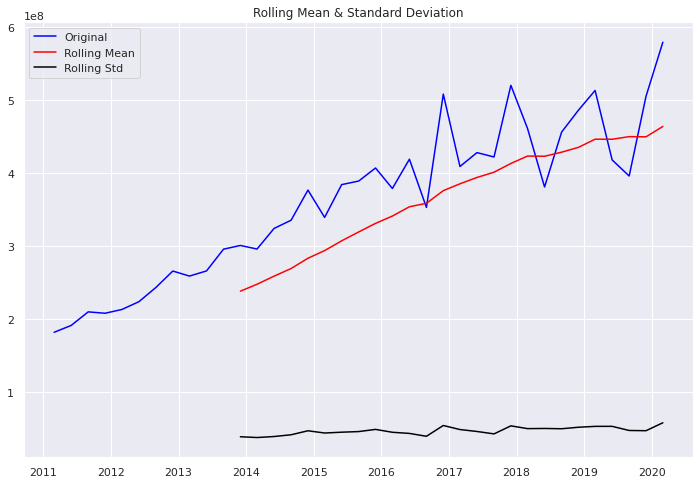

In [ ]:
remove_seasonality = False

if remove_seasonality:
  column_season = list(data.columns)
  items_to_remove = [ 'date', 'month', 'quarter', 'year']
  for item in items_to_remove:
    column_season.remove(item)

  def remove_trend_seasonal(column):
    first_difference = data[column] - data[column].shift(1)
    seasonal_difference = data[column] - data[column].shift(12)
    first_seasonal_difference = first_difference - seasonal_difference
    data[column] = first_seasonal_difference
  for column in column_season:
    remove_trend_seasonal(column)

  data.dropna(inplace=True)

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(data['date'], timeseries, color='blue',label='Original')
    mean = plt.plot(data['date'], rolmean, color='red', label='Rolling Mean')
    std = plt.plot(data['date'], rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

test_stationarity(data['total_revenues'])
data_copy = data.copy() # we will use it later

### **3. Principal Component Analysis - PCA**




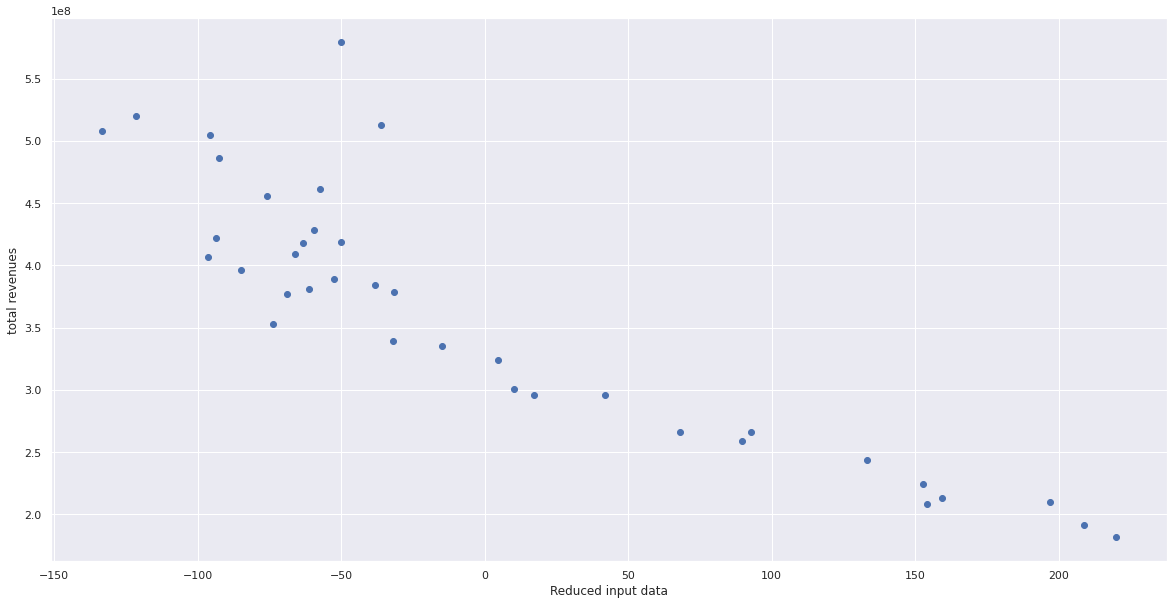

In [ ]:
pca = PCA(n_components=1,
    copy=True,
    whiten=False,
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    random_state=None,)
pca_features = data.drop(['total_revenues', 'date'], axis=1)
principalComponents = pca.fit_transform(pca_features)
plt.figure(figsize=(20,10))
plt.xlabel('Reduced input data')
plt.ylabel('total revenues')
plt.scatter(principalComponents, data['total_revenues'].values)

### **4. Data Scaling**

In [ ]:
#Data scaling
columns_to_NOT_scale = ['total_revenues', 'date', 'month', 'quarter']
columns_to_scale = list(data.columns)
for column in columns_to_NOT_scale:
  columns_to_scale.remove(column)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
data[columns_to_scale] = input_scaler.fit_transform(data[columns_to_scale])
data['total_revenues'] = output_scaler.fit_transform(np.array(data['total_revenues']).reshape(-1, 1))

In [ ]:
data.corr()

,total_revenues,Alcatel,Apple,Asus,BlackBerry,Coolpad,Fujitsu,Gionee,HMD,HTC,Huawei,iTel,Lenovo,LG,Meizu,Micromax,Motorola,Nokia,Oppo,Others,Panasonic,Pantech,Samsung,Sharp,Sony,Tecno,Vivo,Wiko,Xiaomi,ZTE,Grand Total,month,quarter,year
total_revenues,1.000000,0.392640,0.695936,0.655390,-0.848118,-0.374354,-0.782246,0.050087,0.671985,-0.886171,0.853061,0.766393,-0.312186,0.466503,0.615755,0.222252,0.737984,-0.821390,0.871236,0.855386,0.297687,-0.793668,0.638885,0.105591,-0.530716,0.899109,0.863081,0.637988,0.882374,0.144401,0.883350,0.113697,0.113697,0.914624
Alcatel,0.392640,1.000000,0.626460,0.729818,-0.635140,0.534217,-0.465835,0.618568,-0.216498,-0.308546,0.303282,-0.150977,0.609739,0.872026,0.617256,0.846103,0.323424,-0.231740,0.162709,0.581752,0.684527,-0.406453,0.651355,-0.202588,0.294963,0.211322,0.161475,0.635892,0.292984,0.771096,0.672966,0.249668,0.249668,0.237207
Apple,0.695936,0.626460,1.000000,0.631454,-0.653609,0.003542,-0.543047,0.266658,0.293495,-0.587154,0.534052,0.343738,0.085819,0.601073,0.582833,0.376196,0.591143,-0.514719,0.509674,0.686846,0.400930,-0.493255,0.590320,0.112874,-0.066336,0.501397,0.494326,0.732285,0.541726,0.426616,0.792445,0.440147,0.440147,0.507788
Asus,0.655390,0.729818,0.631454,1.000000,-0.662201,-0.033609,-0.547441,0.307649,0.178597,-0.553190,0.625187,0.207677,0.017549,0.577594,0.791755,0.581119,0.494361,-0.493881,0.547018,0.674119,0.666428,-0.696665,0.483994,-0.269829,-0.300357,0.621114,0.560755,0.767390,0.566866,0.510650,0.747433,0.166279,0.166279,0.576088
BlackBerry,-0.848118,-0.635140,-0.653609,-0.662201,1.000000,0.032757,0.800049,-0.271540,-0.459505,0.883874,-0.790554,-0.554312,-0.033981,-0.735196,-0.676558,-0.503568,-0.643157,0.837754,-0.737302,-0.944568,-0.470358,0.709351,-0.898560,-0.003563,0.290217,-0.765256,-0.730771,-0.612388,-0.815410,-0.353096,-0.950209,-0.057528,-0.057528,-0.841050
Coolpad,-0.374354,0.534217,0.003542,-0.033609,0.032757,1.000000,0.191466,0.464434,-0.683759,0.376032,-0.483492,-0.745068,0.976573,0.466940,-0.122233,0.597120,-0.364010,0.375082,-0.646923,-0.149510,0.280808,0.434506,0.275931,-0.147651,0.878514,-0.562705,-0.660485,-0.087741,-0.454189,0.539380,-0.101063,0.072625,0.072625,-0.506651
Fujitsu,-0.782246,-0.465835,-0.543047,-0.547441,0.800049,0.191466,1.000000,-0.038874,-0.570129,0.738657,-0.748658,-0.595694,0.153447,-0.547507,-0.467597,-0.298954,-0.663550,0.599676,-0.711125,-0.821032,-0.189679,0.808673,-0.612343,-0.049533,0.389975,-0.766421,-0.726957,-0.482292,-0.804950,-0.121886,-0.806373,-0.038290,-0.038290,-0.801669
Gionee,0.050087,0.618568,0.266658,0.307649,-0.271540,0.464434,-0.038874,1.000000,-0.575552,0.013618,-0.024467,-0.311728,0.545908,0.664734,0.573355,0.641778,-0.123566,-0.121922,-0.010897,0.342564,0.735969,-0.054209,0.378222,-0.494334,0.278804,-0.179521,-0.060639,0.564236,-0.149324,0.870965,0.320964,0.154738,0.154738,-0.120517
HMD,0.671985,-0.216498,0.293495,0.178597,-0.459505,-0.683759,-0.570129,-0.575552,1.000000,-0.713846,0.661368,0.904970,-0.682549,-0.095336,0.066820,-0.316297,0.720823,-0.599095,0.762297,0.475860,-0.256448,-0.556475,0.232708,0.430589,-0.652864,0.817975,0.780132,0.119393,0.823553,-0.529859,0.471964,0.082710,0.082710,0.796808
HTC,-0.886171,-0.308546,-0.587154,-0.553190,0.883874,0.376032,0.738657,0.013618,-0.713846,1.000000,-0.872369,-0.787625,0.318903,-0.453439,-0.560425,-0.191524,-0.702525,0.888742,-0.883025,-0.874031,-0.261136,0.742579,-0.725876,-0.153138,0.569283,-0.884068,-0.879872,-0.502957,-0.899737,-0.042771,-0.868943,0.015791,0.015791,-0.948764


### **5. Data Encoding**

In [ ]:
#Transform categorical columns to dummies
to_categorical_column = ['month', 'quarter']
for column in to_categorical_column:
  data[column] = data[column].astype('category')
data = pd.get_dummies(data)

In [ ]:
data.head()

,total_revenues,Alcatel,Apple,Asus,BlackBerry,Coolpad,Fujitsu,Gionee,HMD,HTC,Huawei,iTel,Lenovo,LG,Meizu,Micromax,Motorola,Nokia,Oppo,Others,Panasonic,Pantech,Samsung,Sharp,Sony,Tecno,Vivo,Wiko,Xiaomi,ZTE,Grand Total,date,year,month_3,month_6,month_9,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,0.000000,0.000000,0.024510,0.000000,1.000000,0.111748,0.495798,0.088945,0.0,0.730038,0.000000,0.0,0.042424,0.000000,0.000000,0.000000,0.045455,1.000000,0.000000,0.000000,0.000000,0.238889,0.000000,0.512821,0.266481,0.0,0.0,0.0,0.000000,0.050212,0.000000,2011-03-01,0.000000,1,0,0,0,1,0,0,0
1,0.023668,0.008345,0.052288,0.007812,0.913043,0.130850,0.537815,0.127065,0.0,0.901141,0.012195,0.0,0.060606,0.165151,0.000000,0.000000,0.079545,0.690083,0.000000,0.019459,0.000000,0.333333,0.099726,0.427350,0.303621,0.0,0.0,0.0,0.000000,0.116757,0.029746,2011-06-01,0.000000,0,1,0,0,0,1,0,0
2,0.070400,0.022949,0.000000,0.007812,0.847826,0.164279,0.411765,0.165184,0.0,1.000000,0.043554,0.0,0.084848,0.023666,0.015625,0.000000,0.136364,0.694215,0.000000,0.035189,0.046729,0.472222,0.203439,0.598291,0.470752,0.0,0.0,0.0,0.002351,0.183303,0.063785,2011-09-01,0.000000,0,0,1,0,0,0,1,0
3,0.065626,0.036857,0.325163,0.007812,0.971014,0.264565,0.579832,0.216010,0.0,0.775665,0.076655,0.0,0.284848,0.110219,0.023438,0.000000,0.181818,0.809917,0.000000,0.039418,0.093458,0.677778,0.313655,0.598291,0.489322,0.0,0.0,0.0,0.011754,0.292196,0.189722,2011-12-01,0.000000,0,0,0,1,0,0,0,1
4,0.078637,0.047288,0.294118,0.015625,0.717391,0.321872,1.000000,0.228717,0.0,0.509506,0.041812,0.0,0.266667,0.062808,0.039062,0.020183,0.161364,0.491736,0.036775,0.059315,0.140187,0.722222,0.417328,0.683761,0.433612,0.0,0.0,0.0,0.035263,0.237750,0.166868,2012-03-01,0.111111,1,0,0,0,1,0,0,0


### **6. Prepare train and test sets**

In [ ]:
#prepare the data and other stuff for the training
test_rate = 0.2
train_rate = 1 - test_rate
try:
  data.drop('date', axis=1, inplace=True)
except:
  print('Date is already deleted')
train_data = data[:int(data.shape[0]*train_rate)]
test_data = data[-int(data.shape[0]*(test_rate)):]
train_output_data = train_data.pop('total_revenues')
test_output_data = test_data.pop('total_revenues')

### **7. Model evaluation**

In [ ]:
# Selecting some sample models and training using grid search and regressor voting
model_xgb = XGBRegressor()
model_rfr = RandomForestRegressor()
model_lr = LinearRegression()
model_xgb.fit(train_data, train_output_data,
              eval_metric="rmse", 
              eval_set=[(train_data, train_output_data), (test_data, test_output_data)], 
              verbose=True, 
              early_stopping_rounds = 10)
model_rfr.fit(train_data, train_output_data)
model_lr.fit(train_data, train_output_data)

[22:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.243783	validation_1-rmse:0.276302
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.223435	validation_1-rmse:0.26472
[2]	validation_0-rmse:0.204934	validation_1-rmse:0.255963
[3]	validation_0-rmse:0.188117	validation_1-rmse:0.251064
[4]	validation_0-rmse:0.172687	validation_1-rmse:0.24384
[5]	validation_0-rmse:0.158589	validation_1-rmse:0.237342
[6]	validation_0-rmse:0.1457	validation_1-rmse:0.230763
[7]	validation_0-rmse:0.134007	validation_1-rmse:0.231474
[8]	validation_0-rmse:0.123323	validation_1-rmse:0.229241
[9]	validation_0-rmse:0.113455	validation_1-rmse:0.225768
[10]	validation_0-rmse:0.104464	validation_1-rmse:0.222791
[11]	validation_0-rmse:0.096119	validation_1-rmse:0.220753
[12]	validation_0-rm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
model_test_pred = output_scaler.inverse_transform(np.expand_dims(model_xgb.predict(test_data), -1))
model_train_pred = output_scaler.inverse_transform(np.expand_dims(model_xgb.predict(train_data), -1))

### **8. Evaluate feature importance**

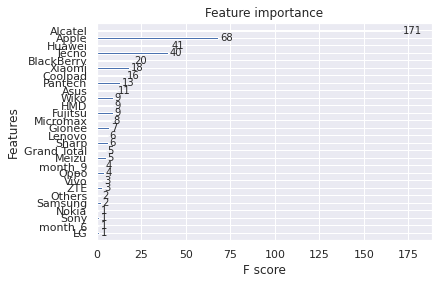

In [ ]:
plot_importance(model_xgb)

### **9. Visualisation - plot predictions vs actuals**

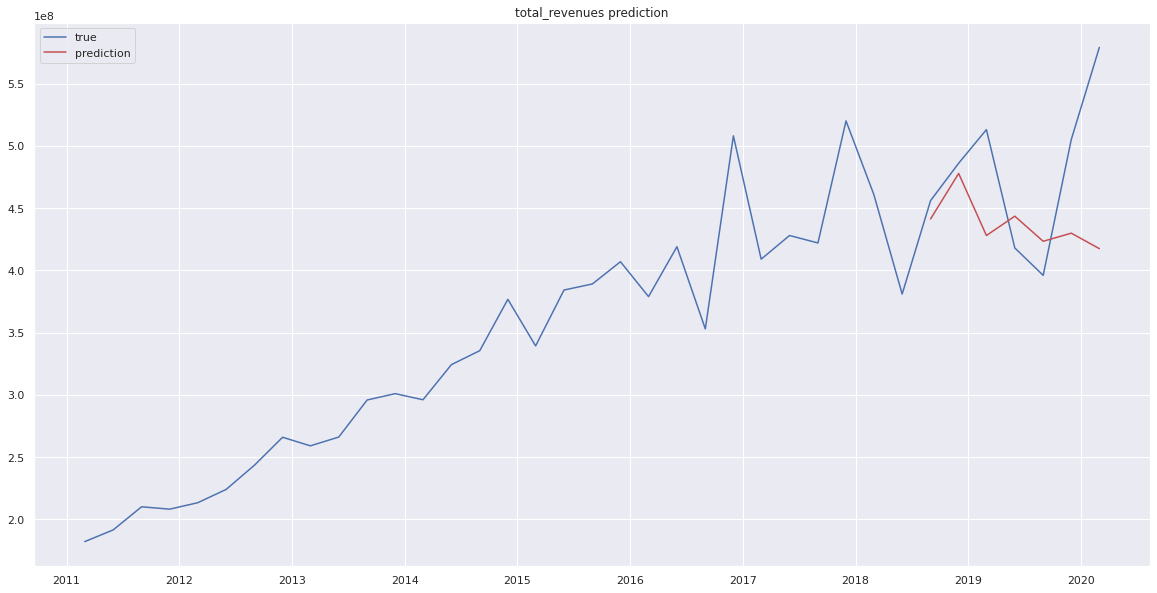

In [ ]:
#plot the results
plt.figure(figsize=(20,10))
plt.plot(data_copy['date'], data_copy['total_revenues'])
plt.title('total_revenues prediction')
plt.plot(data_copy['date'][-int(data.shape[0]*(test_rate)):], model_test_pred, 'r')
plt.legend(['true', 'prediction'])

### **10. SHAP Feature selection and explanation**

In [ ]:
#SHAP
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(data.drop('total_revenues', axis=1))

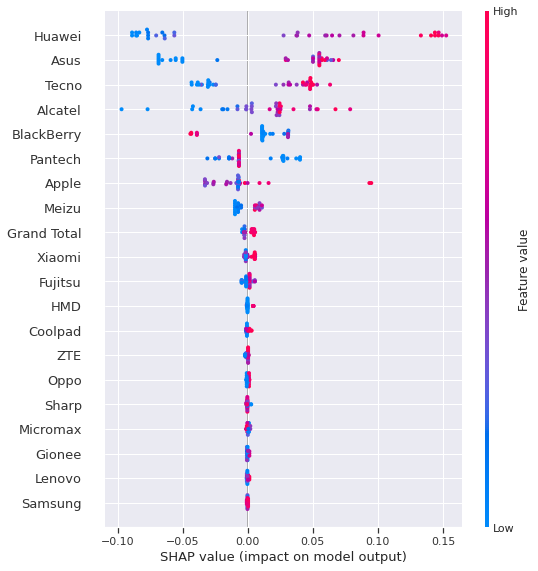

In [ ]:
shap.summary_plot(shap_values, data.drop('total_revenues', axis=1))

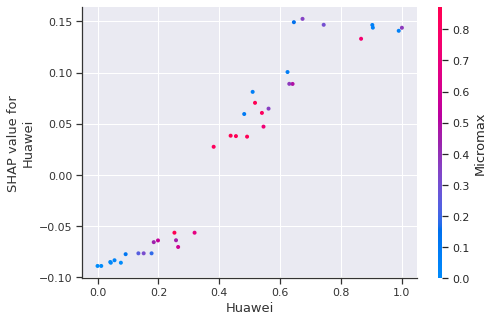

In [ ]:
#Use whatever company to visualize the correlation, x axis value are normalized
company = "Huawei"
shap.dependence_plot(company, shap_values, data.drop('total_revenues', axis=1))

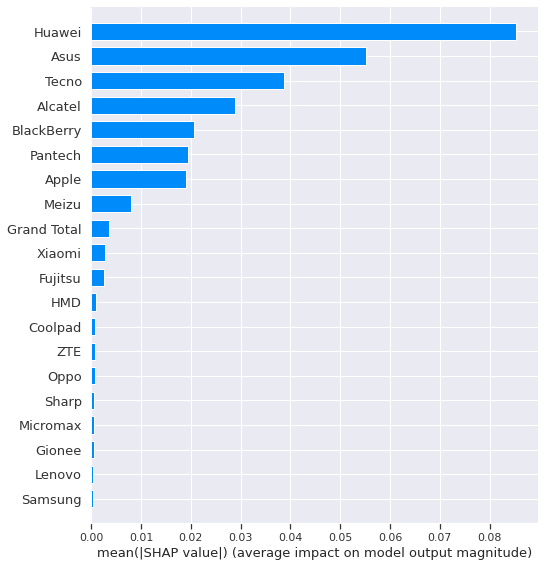

In [ ]:
shap.summary_plot(shap_values, data.drop('total_revenues', axis=1), plot_type="bar")

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data.drop('total_revenues', axis=1))

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], data.drop('total_revenues', axis=1).iloc[0,:])